In [2]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imutils
import src.localizator as localizator
import json

In [5]:
TRAIN = "training_data"

In [6]:
def draw_codes(imgs):
    bd = cv2.barcode.BarcodeDetector()
    qcd = cv2.QRCodeDetector()

    fig, axs = plt.subplots(3, len(imgs) // 3 + 1, figsize=(20, 20))
    for i, img in enumerate(imgs):
        res_img = cv2.imread(img)
        _, data, points, _ = bd.detectAndDecodeMulti(res_img)
        if points is not None:
            for p in points:
                # print(np.array(p, dtype=np.int32))
                res_img = cv2.polylines(res_img, [np.array(p, dtype=np.int32)], True, (0, 255, 0), 3)
            for s, p in zip(data, points):
                res_img = cv2.putText(res_img, s, p[1].astype(int),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

        _, data, points, _ = qcd.detectAndDecodeMulti(res_img)
        if points is not None:
            for p in points:
                # print(np.array(p, dtype=np.int32))
                res_img = cv2.polylines(res_img, [np.array(p, dtype=np.int32)], True, (0, 255, 0), 3)
            for s, p in zip(data, points):
                res_img = cv2.putText(res_img, s, p[1].astype(int),
                      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        axs[i % 3][i // 3].imshow(res_img)
        axs[i % 3][i // 3].set_title(img)

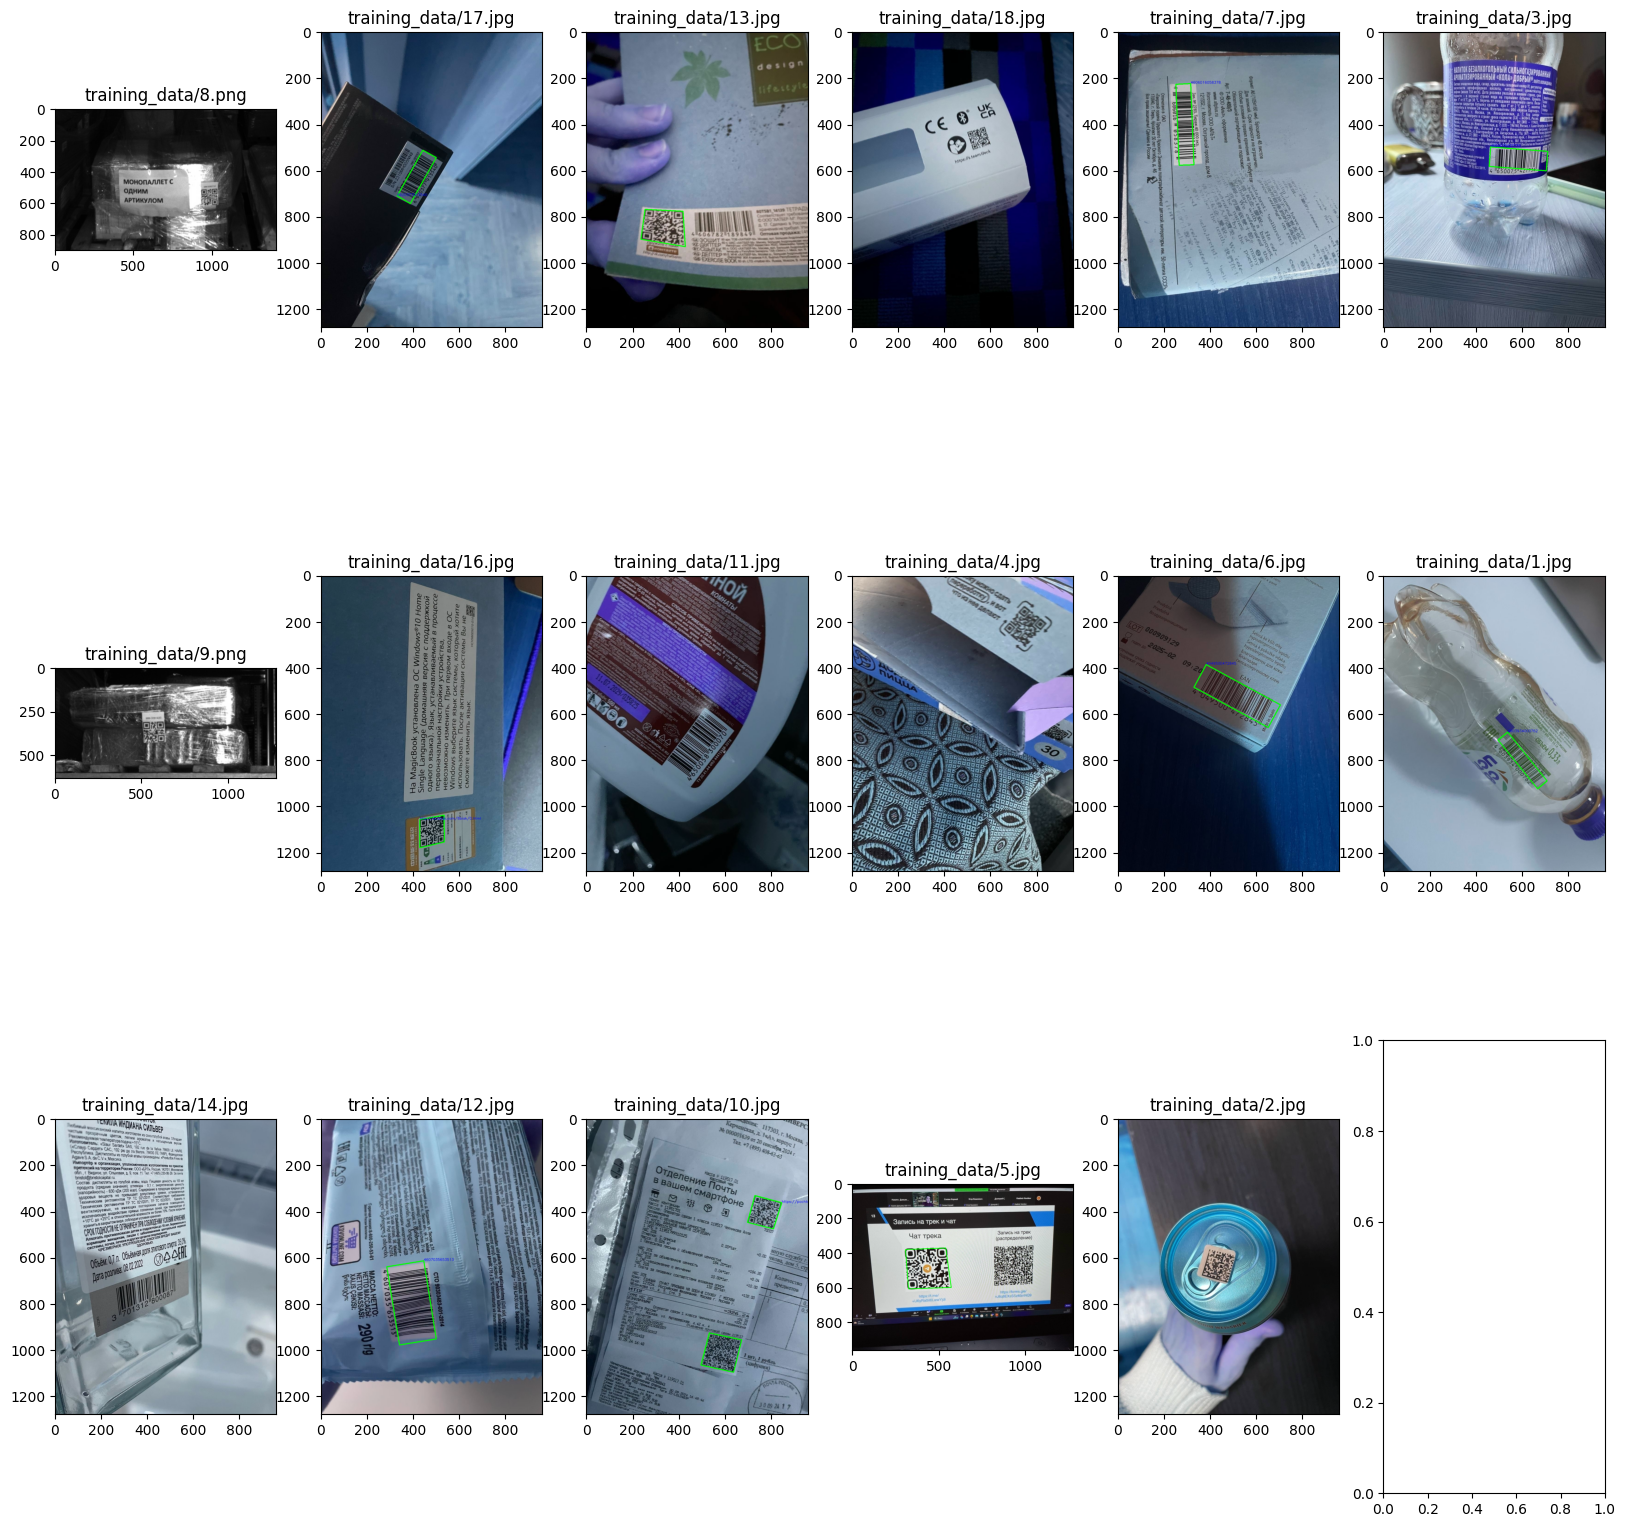

In [108]:
imgs = glob.glob(os.path.join(TRAIN, "*"))
draw_codes(imgs=imgs)

In [96]:
def localize(img) -> list[int]:
        """
        Localizes all barcodes and QR codes in the given image.

        :param img: Image where barcodes and QR codes should be localized.
        :return: List of 2D points of the detected barcodes and QR codes.
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        gradX = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
        gradY = cv2.Scharr(gray, cv2.CV_64F, 0, 1)

        gradient = cv2.subtract(gradX, gradY)
        gradient = cv2.convertScaleAbs(gradient)

        blurred = cv2.blur(gradient, (9, 9))
        _, thresh = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Perform erosions and dilations to remove small regions
        closed = cv2.erode(closed, None, iterations=4)
        closed = cv2.dilate(closed, None, iterations=4)

        contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        c = sorted(contours, key=cv2.contourArea, reverse=True)[0]

        # Compute the rotated bounding box of the largest contour
        hull = cv2.convexHull(c)

        return [hull]

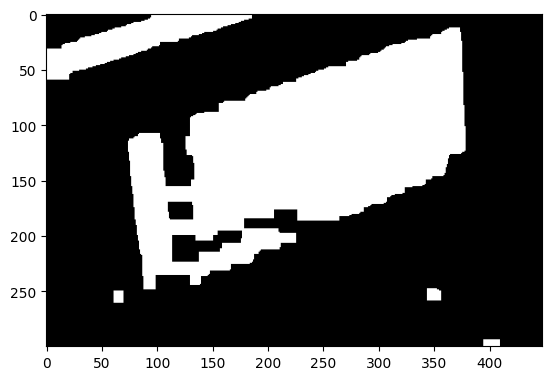

In [ ]:
img_src = "image.png"
img = cv2.imread(img_src)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)

gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)

blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 190, 255, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

closed = cv2.erode(closed, None, iterations = 4)
closed = cv2.dilate(closed, None, iterations = 4)

img_rgb = cv2.cvtColor(closed, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [94]:
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)

epsilon = 0.01*cv2.arcLength(c,True)
approx = cv2.approxPolyDP(c,epsilon,True)

hull = cv2.convexHull(c)

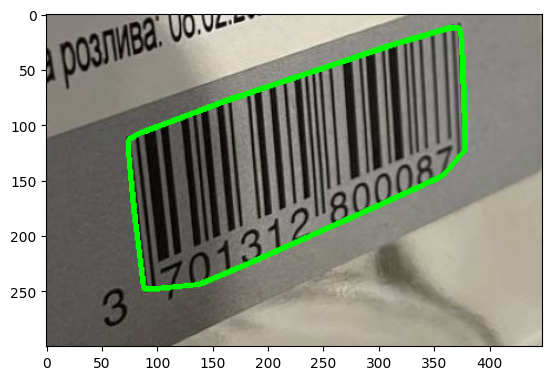

In [95]:
cv2.drawContours(img, [hull], -1, (0, 255, 0), 3)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [54]:
class Localizator:
    def __init__(self):
        """
        Initializes the Localizator class.

        Creates BarcodeDetector and QRCodeDetector instances.
        """
        self.bd = cv2.barcode.BarcodeDetector()
        self.qcd = cv2.QRCodeDetector()

    def localize_opencv(self, img) -> list[int]:
        """
        Localizes all barcodes and QR codes in the given image.

        :param img: Image where barcodes and QR codes should be localized.
        :return: List of 2D points of the detected barcodes and QR codes.
        """
        barcodes = []

        bd_ret, _, bd_points, _ = self.bd.detectAndDecodeMulti(img)
        qcd_ret, _, qcd_points, _ = self.qcd.detectAndDecodeMulti(img)

        if bd_ret:
            barcodes.extend(np.array(bd_points, dtype=np.int32))

        if qcd_ret:
            barcodes.extend(np.array(qcd_points, dtype=np.int32))

        return barcodes

    def localize(self, img, min_thresh: int = 190, max_thresh: int = 255, kernel_size: tuple = (21, 7)) -> list[int]:
        """
        Localizes barcode or QR code in the given image. It should be guranteed that
        there is only one barcode or QR code in the image and it takes the largest part of the image.

        :param img: Image where barcodes and QR codes should be localized.
        :return: List of 2D points of the detected barcodes and QR codes.
        """
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        gradX = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
        gradY = cv2.Scharr(gray, cv2.CV_64F, 0, 1)

        gradient = cv2.subtract(gradX, gradY)
        gradient = cv2.convertScaleAbs(gradient)

        blurred = cv2.blur(gradient, (9, 9))
        _, thresh = cv2.threshold(blurred, min_thresh, max_thresh, cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Perform erosions and dilations to remove small regions
        closed = cv2.erode(closed, None, iterations=4)
        closed = cv2.dilate(closed, None, iterations=4)

        contours, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return []

        c = sorted(contours, key=cv2.contourArea, reverse=True)[0]

        # Compute the rotated bounding box of the largest contour
        hull = cv2.convexHull(c)

        return hull


In [55]:
CONF = "annotations.json"
TEST_DATA = "training_data"
DIR_IMGS = "output"

class ViaImgMetadataParser:
    def __init__(self, json_file, dir_imgs):
        self.json_data = json.load(open(json_file, "r"))
        self.img_metadata = self.json_data["_via_img_metadata"]
        self.dir_imgs = dir_imgs
        self.polygons = self.load_polygons()

    def load_polygons(self):
        polygons = []
        for _, img_data in self.img_metadata.items():
            regions = img_data["regions"]
            for region in regions:
                if region["shape_attributes"]["name"] == "polygon":
                    all_points_x = region["shape_attributes"]["all_points_x"]
                    all_points_y = region["shape_attributes"]["all_points_y"]
                    polygon_points = list(zip(all_points_x, all_points_y))
                    polygons.append({
                        "polygon": polygon_points,
                        "img": os.path.join(self.dir_imgs, img_data["filename"]),
                    })
        return polygons

    def __iter__(self):
        return ViaPolygonsIterator(self.polygons)

    def __len__(self):
        return len(self.polygons)


class ViaPolygonsIterator:
    def __init__(self, polygons):
        self.polygons = polygons
        self.index = 0

    def __next__(self):
        if self.index < len(self.polygons):
            img_id = self.polygons[self.index]["img"]
            polygon_points = self.polygons[self.index]["polygon"]
            self.index += 1
            return img_id, polygon_points
        else:
            raise StopIteration


def create_box_image(image, polygon):
    x, y, w, h = cv2.boundingRect(np.array([polygon], dtype=np.int32))
    box_image = np.zeros((h, w, 3), dtype=np.uint8)

    box_image[:, :] = image[y : y + h, x : x + w]

    relative_polygon = polygon - np.array([x, y])

    return box_image, relative_polygon


def calculate_iou(polygon1, polygon2, image):
    if len(polygon1) == 0 or len(polygon2) == 0:
        return 0
    height, width, _ = image.shape

    mask1 = np.zeros((height, width), dtype=np.int32)
    cv2.drawContours(mask1, [polygon1], -1, 255, -1)

    mask2 = np.zeros((height, width), dtype=np.int32)
    cv2.drawContours(mask2, [polygon2], -1, 255, -1)

    intersection = cv2.bitwise_and(mask1, mask2)
    union = cv2.bitwise_or(mask1, mask2)

    iou = np.sum(intersection) / np.sum(union)

    return iou


def test_detect_object_and_calculate_iou(conf: str, dir_imgs: str, output: str):
    loc = Localizator()

    for index, img_path, polygon_points in enumerate(ViaImgMetadataParser(conf, dir_imgs)):
        res_img = cv2.imread(img_path)

        box_image, relative_polygon = create_box_image(res_img, polygon_points)

        points = loc.localize(box_image)

        assert points is not None

        iou = calculate_iou(relative_polygon, points, box_image)

        cv2.drawContours(box_image, [relative_polygon], -1, (0, 255, 0), 2)
        cv2.drawContours(box_image, [points], -1, (0, 0, 255), 2)
        cv2.putText(box_image, f"IoU: {iou:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imwrite(os.path.join(output, f"i_{index}_{os.path.basename(img_path)}"), box_image)


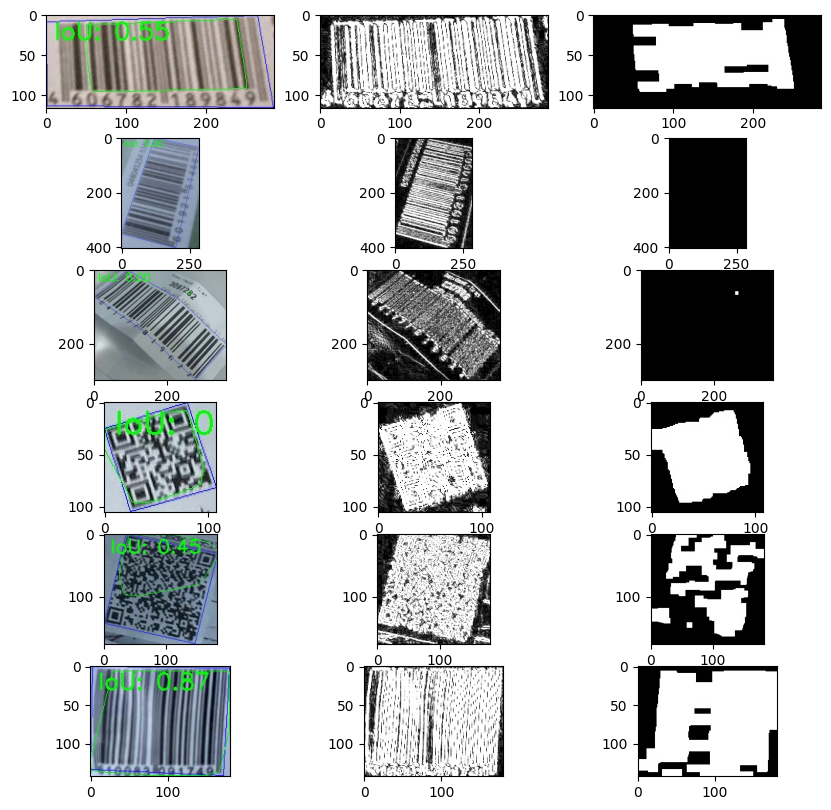

In [ ]:
import random
n = 6
fig, axs = plt.subplots(n, 3, figsize=(10, 10))

for i, folder in enumerate(random.sample(glob.glob('output/*'), 6)):
    img = cv2.imread(os.path.join(folder, 'img.jpg'))
    gradient = cv2.imread(os.path.join(folder, 'gradient.jpg'))
    closed = cv2.imread(os.path.join(folder, 'closed.jpg'))

    axs[i][0].imshow(img)
    axs[i][1].imshow(gradient)
    axs[i][2].imshow(closed)

Variance grid:
[np.float64(715.8358696419746), np.float64(11035.427087379068), np.float64(9421.229952642823), np.float64(8721.279534240166), np.float64(5159.638521952899), np.float64(10049.23248269896), np.float64(9608.979855545158), np.float64(10413.068029049855), np.float64(7590.287310880235), np.float64(10074.774305310359)]
[np.float64(334.61984389343974), np.float64(11512.059846365019), np.float64(1647.7666202510418), np.float64(6070.503582683073), np.float64(6114.313889158605), np.float64(9953.182208177386), np.float64(4718.789258350399), np.float64(5976.076247042935), np.float64(10442.575479088695), np.float64(10001.698378248358)]
[np.float64(447.93471506249557), np.float64(9969.658917978955), np.float64(2150.1967099339736), np.float64(6352.996097335994), np.float64(5264.132713747264), np.float64(3296.029994350682), np.float64(7718.1339197443685), np.float64(9718.653678015324), np.float64(8555.47608639044), np.float64(5615.343353885672)]
[np.float64(1481.6440223148084), np.float6

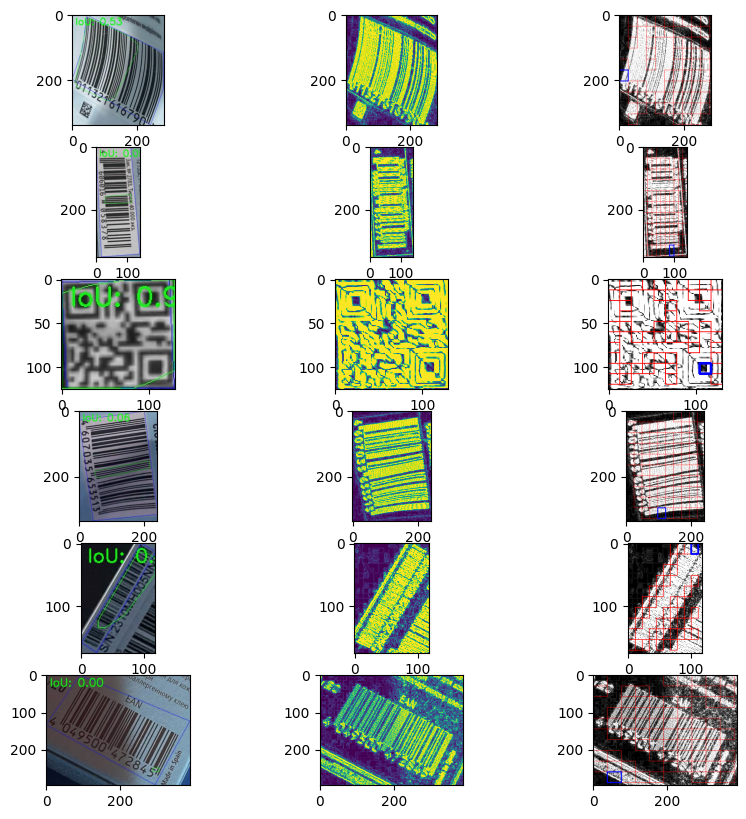

In [ ]:
import random
n = 6
fig, axs = plt.subplots(n, 3, figsize=(10, 10))


sub_var = 2000
sup_var = 6000

def bfs(var, img, x, y, cell_heiht, cell_width):
    queue = [(x, y)]
    visited = set()
    while queue:
        x, y = queue.pop(0)
        visited.add((x, y))
        for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (1, -1), (-1, -1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < var.shape[0] and 0 <= ny < var.shape[1] and (nx, ny) not in visited:
                if var[nx, ny] >= sub_var:
                    queue.append((nx, ny))
                    cv2.rectangle(image_copy, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)
    return len(visited)

for k, folder in enumerate(random.sample(glob.glob('output/*'), 6)):
    img = cv2.imread(os.path.join(folder, 'img.jpg'))
    image = cv2.imread(os.path.join(folder, 'gradient.jpg'), cv2.IMREAD_GRAYSCALE)
    axs[k][0].imshow(img)
    axs[k][1].imshow(image)

    image_copy = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    height, width = image.shape
    rows, cols = 10, 10

    cell_height = height // rows
    cell_width = width // cols

    variances = []

    for i in range(rows):
        row_variances = []
        for j in range(cols):
            x_start = j * cell_width
            x_end = x_start + cell_width
            y_start = i * cell_height
            y_end = y_start + cell_height

            cell = image[y_start:y_end, x_start:x_end]

            variance = np.var(cell)
            row_variances.append(variance)

            center_x = x_start + cell_width // 2
            center_y = y_start + cell_height // 2

            variance_str = f'{variance:.2f}'

            if variance > sup_var:
                cv2.rectangle(image_copy, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)

        variances.append(row_variances)

    max_i, max_j = 0, 0
    max_var = 0
    for i in range(rows):
        for j in range(cols):
            if variances[i][j] > max_var:
                max_i = i
                max_j = j
                max_var = variances[i][j]


    cv2.rectangle(image_copy, (max_j * cell_width, max_i * cell_height), ((max_j + 1) * cell_width, (max_i + 1) * cell_height), (0, 0, 255), 2)

    axs[k][2].imshow(image_copy)

    # Variances as a 2D grid
    print("Variance grid:")
    for row in variances:
        print(row)


In [ ]:
loc = Localizator()



for img_path, polygon_points in ViaImgMetadataParser(CONF, TEST_DATA):
    res_img = cv2.imread(img_path)
    print(img_path, polygon_points)

    box_image, relative_polygon = create_box_image(res_img, polygon_points)

    points = loc.localize(box_image)

    cv2.drawContours(box_image, np.array([relative_polygon], dtype=np.int32), -1, (0, 0, 255), 2)
    print(points)
    cv2.drawContours(box_image, np.array([points], dtype=np.int32), -1, (0, 255, 0), 2)

    iou = calculate_iou(relative_polygon, points, box_image)

    cv2.putText(box_image, f"IoU: {iou:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(box_image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()


In [45]:
len(ViaImgMetadataParser(CONF, TEST_DATA))

45

In [ ]:
def draw_rectangle_with_opacity(image, top_left, bottom_right, color, opacity):
    """
    Draws a rectangle with opacity on the given image.

    Parameters:
        image (ndarray): The original image.
        top_left (tuple): Top-left corner of the rectangle (x, y).
        bottom_right (tuple): Bottom-right corner of the rectangle (x, y).
        color (tuple): Color of the rectangle in BGR format (e.g., (0, 255, 0) for green).
        opacity (float): Opacity of the rectangle (0.0 to 1.0).

    Returns:
        image_with_rectangle (ndarray): Image with the translucent rectangle.
    """

    # sub_img = img[y:y+h, x:x+w]
    # white_rect = np.ones(sub_img.shape, dtype=np.uint8) * 255

    # res = cv2.addWeighted(sub_img, 0.5, white_rect, 0.5, 1.0)

    # # Putting the image back to its position
    # img[y:y+h, x:x+w] = res

    # Create a copy of the image to draw the rectangle on
    overlay = image.copy()

    # Draw the rectangle on the overlay
    cv2.rectangle(overlay, top_left, bottom_right, color, -1)  # -1 fills the rectangle

    # Blend the overlay with the original image
    blended = cv2.addWeighted(overlay, opacity, image, 1 - opacity, 0.5)

    return blended

In [91]:
def bfs(var, img, x, y, cell_heiht, cell_width):
    queue = [(x, y)]
    visited = set()
    while queue:
        x, y = queue.pop(0)
        visited.add((x, y))
        for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (1, -1), (-1, -1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < var.shape[0] and 0 <= ny < var.shape[1] and (nx, ny) not in visited:
                if var[nx, ny] >= sub_var:
                    queue.append((nx, ny))
                    cv2.rectangle(image_copy, (x_start, y_start), (x_end, y_end), (255, 0, 0), 1)
    return len(visited)


def visualize_hog(image, cell_size=(10, 10), num_cells = (7, 7), block_size=(2, 2), nbins=12):
    # Step 1: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    scale = 4
    rescaled = cv2.resize(image, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    rescaled_copy = rescaled.copy()

    # Step 2: Compute gradients
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=1)
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    # Step 3: Create HOG histogram for each cell
    # cell_x, cell_y = cell_size
    # num_cells_x = gray.shape[1] // cell_x
    # num_cells_y = gray.shape[0] // cell_y

    num_cells_x, num_cells_y = num_cells
    cell_x, cell_y = gray.shape[1] // num_cells_x, gray.shape[0] // num_cells_y
    bin_width = 180 / nbins
    hog_image = np.zeros_like(gray, dtype=np.float32)

    probs = []
    # Iterate over each cell
    for i in range(num_cells_y):
        probs_i = []
        for j in range(num_cells_x):
            # Extract the cell's gradients
            cell_magnitude = magnitude[i * cell_y:(i + 1) * cell_y, j * cell_x:(j + 1) * cell_x]
            cell_angle = angle[i * cell_y:(i + 1) * cell_y, j * cell_x:(j + 1) * cell_x]

            # Compute histogram
            hist = np.zeros(nbins, dtype=np.float32)
            for k in range(cell_magnitude.shape[0]):
                for l in range(cell_magnitude.shape[1]):
                    bin_idx = int(cell_angle[k, l] // bin_width) % nbins
                    hist[bin_idx] += cell_magnitude[k, l]

            # Find two dominant directions
            dominant_indices = hist.argsort()[-2:][::-1]  # Indices of the top 2 bins

            for s, idx in enumerate(dominant_indices):
                theta = (idx + 0.5) * bin_width  # Center of the bin
                theta_rad = np.deg2rad(theta)

                # Arrow parameters
                center_x = int(scale * (j * cell_x + cell_x // 2))
                center_y = int(scale * (i * cell_y + cell_y // 2))

                # center_x = j * cell_x + cell_x // 2
                # center_y = i * cell_y + cell_y // 2
                length = hist[idx] / np.max(hist) * cell_x // 2

                # dx = int(scale * cell_x // 4 * np.cos(theta_rad))
                # dy = int(scale * cell_x // 4 * np.sin(theta_rad))

                dx = int(scale * length * np.cos(theta_rad))
                dy = int(scale * length * np.sin(theta_rad))

                # Draw the arrow
                if s == 0:
                    cv2.arrowedLine(rescaled, (center_x, center_y),
                                (center_x + dx, center_y - dy),
                                (255, 0, 0), 1, tipLength=0.2)
                else:
                    cv2.arrowedLine(rescaled, (center_x, center_y),
                                (center_x + dx, center_y - dy),
                                (0, 255, 0), 1, tipLength=0.2)

            theta_1 = (dominant_indices[0] + 0.5) * bin_width
            theta_2 = (dominant_indices[1] + 0.5) * bin_width

            p = (1 - np.abs(np.abs(theta_1 - theta_2) - 90) / 90) * (2 * min(dominant_indices[0], dominant_indices[1])) / (dominant_indices[1] + dominant_indices[0])
            probs_i.append(p)
            top_left = (int(scale * j * cell_x), int(scale * i * cell_y))
            bottom_right = (int(scale * (j + 1) * cell_x), int(scale * (i + 1) * cell_y))
            # cv2.rectangle(rescaled, top_left, bottom_right, (0, 0, 255), 1)
            rescaled = draw_rectangle_with_opacity(rescaled, top_left, bottom_right, (0, 0, 255), p)

        probs.append(probs_i)

    # probs = np.array(probs)

    segmentation = np.zeros_like(probs, dtype=np.bool)

    porog = 0.21
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            if probs[i][j] > porog:
                segmentation[i][j] = True

    new_segmentation = np.zeros_like(probs, dtype=np.bool)

    for i in range(num_cells_y):
        for j in range(num_cells_x):
            if segmentation[i][j] == True:
                new_segmentation[i][j] = True
                continue
            cnt = 0
            for dx, dy in [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (1, -1), (-1, -1)]:
                nx, ny = i + dx, j + dy
                if 0 <= nx < num_cells_y and 0 <= ny < num_cells_x and segmentation[nx][ny] == True:
                    cnt += 1

            if cnt >= 2:
                new_segmentation[i][j] = True

    segmentation = new_segmentation
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            if segmentation[i][j] == True:
                top_left = (int(scale * j * cell_x), int(scale * i * cell_y))
                bottom_right = (int(scale * (j + 1) * cell_x), int(scale * (i + 1) * cell_y))
                rescaled_copy = draw_rectangle_with_opacity(rescaled_copy, top_left, bottom_right, (0, 255, 0), 0.8)


    print(probs)
    return rescaled, rescaled_copy

# Load image
image = cv2.imread("output/ind_0_img_2/start.jpg")

# Visualize HOG
hog_vis, image_copy = visualize_hog(image)

[[np.float64(0.1333333333333333), np.float64(0.0), np.float64(0.0), np.float64(0.25), np.float64(0.0), np.float64(0.0), np.float64(0.15555555555555553)], [np.float64(0.11111111111111109), np.float64(0.0), np.float64(0.25), np.float64(0.1538461538461538), np.float64(0.0), np.float64(0.25), np.float64(0.0)], [np.float64(0.0), np.float64(0.25), np.float64(0.11111111111111109), np.float64(0.25), np.float64(0.0), np.float64(0.25), np.float64(0.25)], [np.float64(0.0), np.float64(0.25), np.float64(0.25), np.float64(0.25), np.float64(0.1538461538461538), np.float64(0.1538461538461538), np.float64(0.2380952380952381)], [np.float64(0.0), np.float64(0.25), np.float64(0.25), np.float64(0.0), np.float64(0.25), np.float64(0.25), np.float64(0.0)], [np.float64(0.25), np.float64(0.1538461538461538), np.float64(0.1538461538461538), np.float64(0.25), np.float64(0.25), np.float64(0.25), np.float64(0.0)], [np.float64(0.0), np.float64(0.15789473684210523), np.float64(0.1538461538461538), np.float64(0.153846

[[np.float64(0.1538461538461538), np.float64(0.33333333333333337), np.float64(0.1333333333333333), np.float64(0.15555555555555553), np.float64(0.15686274509803919), np.float64(0.0), np.float64(0.0)], [np.float64(0.0), np.float64(0.1538461538461538), np.float64(0.4), np.float64(0.4), np.float64(0.27777777777777785), np.float64(0.27777777777777785), np.float64(0.1538461538461538)], [np.float64(0.0), np.float64(0.38461538461538464), np.float64(0.15555555555555553), np.float64(0.1515151515151515), np.float64(0.1515151515151515), np.float64(0.3703703703703704), np.float64(0.15686274509803919)], [np.float64(0.1333333333333333), np.float64(0.15686274509803919), np.float64(0.15686274509803919), np.float64(0.1515151515151515), np.float64(0.2857142857142857), np.float64(0.15686274509803919), np.float64(0.1333333333333333)], [np.float64(0.15686274509803919), np.float64(0.1333333333333333), np.float64(0.1515151515151515), np.float64(0.1515151515151515), np.float64(0.27777777777777785), np.float64(

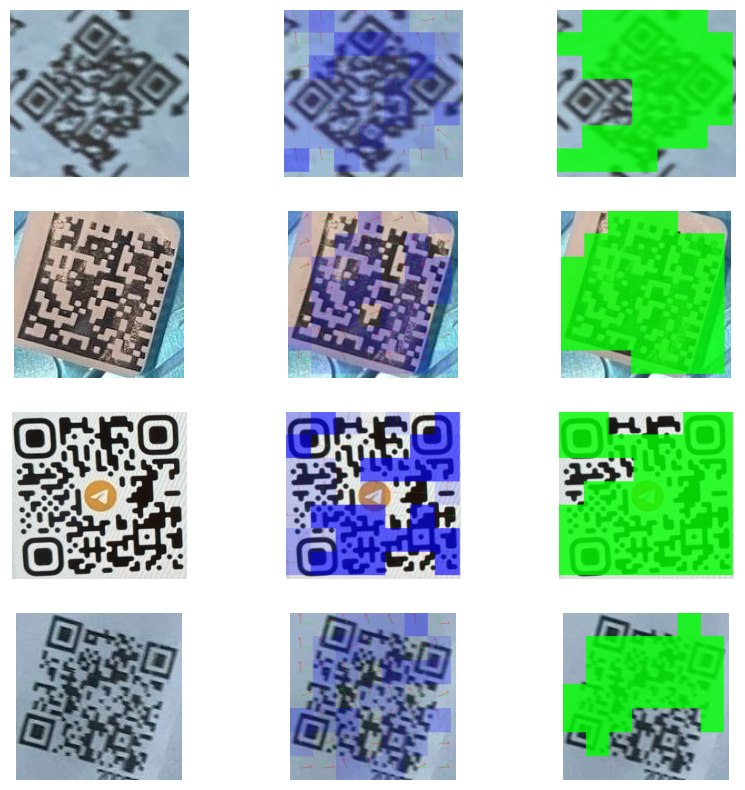

In [92]:
pathes = [
    '/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_4/start.jpg',
    "output/ind_0_img_2/start.jpg",
    "/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_5/start.jpg",
    "/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_10/start.jpg"
]

n = len(pathes)
fig, axs = plt.subplots(n, 3, figsize=(10, 10))

for i, folder in enumerate(pathes):
    img = cv2.imread(folder)

    hog_vis, image_copy = visualize_hog(img)

    axs[i][0].axis('off')
    axs[i][1].axis('off')
    axs[i][2].axis('off')
    axs[i][0].imshow(img)
    axs[i][1].imshow(hog_vis)
    axs[i][2].imshow(image_copy)

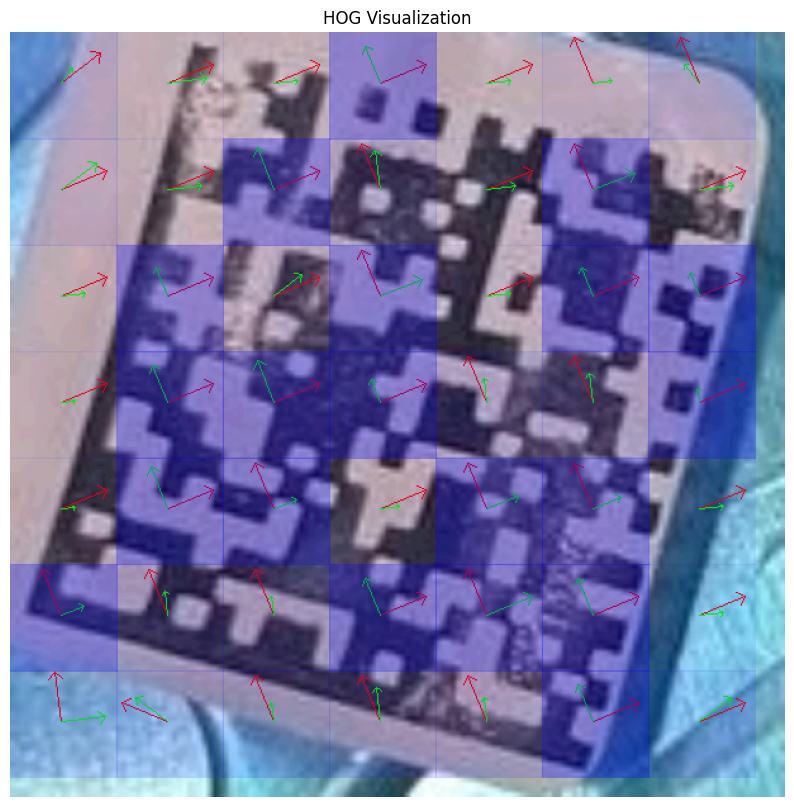

In [65]:
plt.figure(figsize=(10, 10))
plt.imshow(hog_vis, cmap="gray")
plt.title("HOG Visualization")
plt.axis("off")
plt.show()

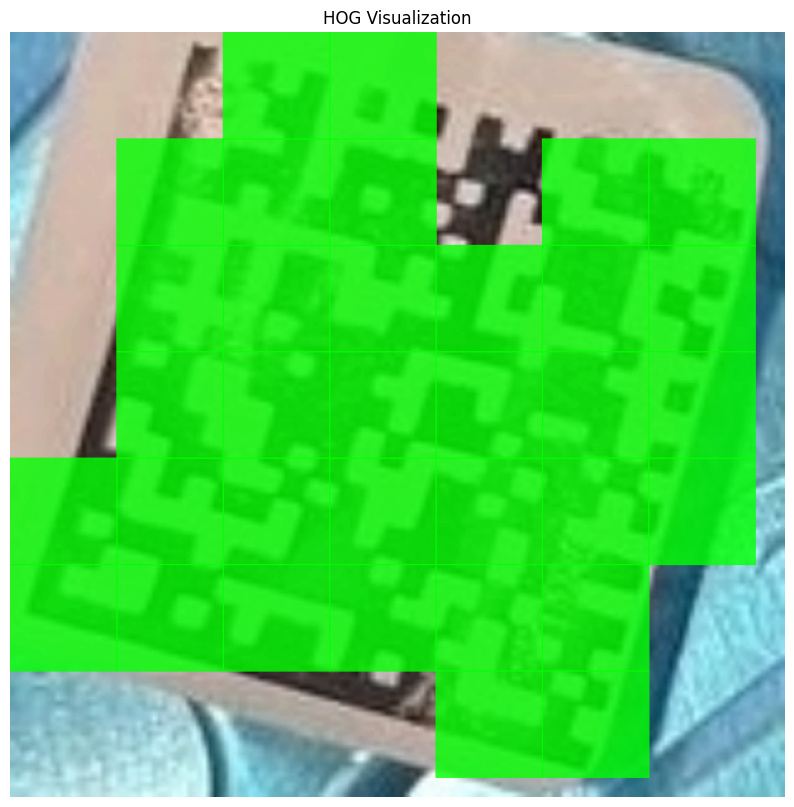

In [66]:
plt.figure(figsize=(10, 10))
plt.imshow(image_copy, cmap="gray")
plt.title("HOG Visualization")
plt.axis("off")
plt.show()

In [4]:
from collections import deque

def compute_local_dispersion_and_threshold(image, box_size, threshold):
    """
    Computes local dispersion (variance) for each pixel in the image
    and thresholds the result to create a binary image.

    Parameters:
        image (np.ndarray): Grayscale input image.
        box_size (int): Size of the square box (must be odd) centered around each pixel.
        threshold (float): Threshold value for dispersion.

    Returns:
        np.ndarray: Binary image (black and white) based on dispersion threshold.
    """
    if len(image.shape) != 2:
        raise ValueError("Input image must be a grayscale image.")
    if box_size % 2 == 0:
        raise ValueError("Box size must be an odd number.")

    # Padding to handle edges
    pad_size = box_size // 2
    padded_image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)

    # Compute the mean filter and mean of squares
    kernel = np.ones((box_size, box_size), dtype=np.float32) / (box_size ** 2)
    local_mean = cv2.filter2D(padded_image, -1, kernel)[pad_size:-pad_size, pad_size:-pad_size]
    local_mean_sq = cv2.filter2D(padded_image**2, -1, kernel)[pad_size:-pad_size, pad_size:-pad_size]

    # Compute local variance (dispersion)
    local_dispersion = local_mean_sq - local_mean**2

    # Threshold the dispersion to create a binary image
    binary_image = np.where(local_dispersion > threshold, 255, 0).astype(np.uint8)

    return binary_image

def bfs_on_white_pixels_with_visited(image, center, radius):
    """
    Performs a BFS starting from the center of the image, moving only through white pixels.
    Draws a white circle in the center before performing BFS and creates an image marking all visited pixels.

    Parameters:
        image (np.ndarray): Binary input image (0 for black, 255 for white).
        center (tuple): Coordinates (x, y) of the circle's center.
        radius (int): Radius of the white circle to be drawn in the center.

    Returns:
        np.ndarray: Image showing BFS traversal path.
        np.ndarray: Image marking every visited pixel.
    """
    # Draw the white circle in the center
    bfs_image = image.copy()
    visited_image = np.zeros_like(image)  # To record visited pixels
    cv2.circle(bfs_image, center, radius, 255, -1)  # Fill the circle with white

    # Create a BFS queue and a visited set
    queue = deque([center])
    visited = set([center])

    # Define possible movement directions (4-connectivity)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    # Perform BFS
    while queue:
        x, y = queue.popleft()

        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # Check bounds and if the pixel is white and not visited
            if (0 <= nx < bfs_image.shape[1] and 0 <= ny < bfs_image.shape[0] and
                (nx, ny) not in visited and bfs_image[ny, nx] == 255):
                bfs_image[ny, nx] = 128  # Mark the path (gray)
                visited_image[ny, nx] = 255  # Mark as visited
                queue.append((nx, ny))
                visited.add((nx, ny))

    return bfs_image, visited_image

[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [  0 255   0 ... 255 255 255]]
[[  0   0   0 ... 255 255 255]
 [  0   0   0 ...   0   0 255]
 [  0   0 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[  0   0   0 ... 255   0 255]
 [  0   0 255 ... 255   0 255]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255 255   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[255 255 255 ... 255   0   0]
 [255 255 255 ... 255   0   0]
 [255 255 255 ... 255 255   0]
 ...
 [255 255 255 ...   0   0   0]
 [255 255 255 ... 255   0   0]
 [255 255 255 ... 255   0   0]]


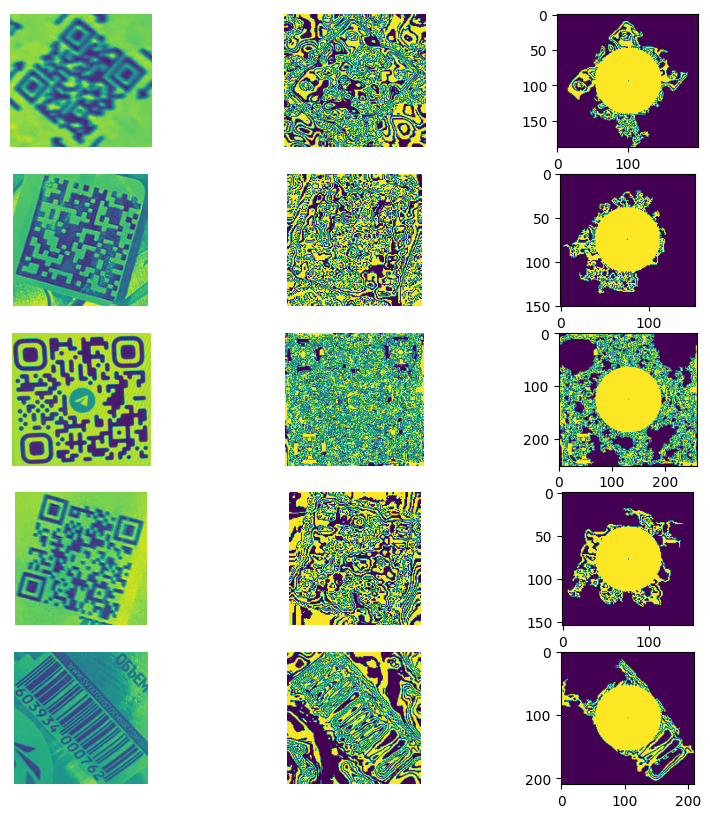

In [ ]:
pathes = [
    '/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_4/start.jpg',
    "output/ind_0_img_2/start.jpg",
    "/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_5/start.jpg",
    "/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_10/start.jpg",
    "/Users/dankovns/study/mipt2024f_dankov_n_s/output/ind_0_img_1/start.jpg"
]

n = len(pathes)
fig, axs = plt.subplots(n, 3, figsize=(10, 10))

for i, folder in enumerate(pathes):
    img = cv2.imread(folder, cv2.IMREAD_GRAYSCALE)

    axs[i][0].axis('off')
    axs[i][1].axis('off')
    axs[i][0].imshow(img)

    # Compute local dispersion with a 5x5 box
    box_size = 15

    dispersion_image = compute_local_dispersion_and_threshold(img, box_size, 100)

    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = min(img.shape[1] // 4, img.shape[0] // 4)

    bfs_image, visited_image = bfs_on_white_pixels_with_visited(dispersion_image, center, radius)


    print(dispersion_image, calculate_iou())

    axs[i][1].imshow(dispersion_image)
    axs[i][2].imshow(visited_image)

In [ ]:


for index, img_path, polygon_points in enumerate(ViaImgMetadataParser(conf, dir_imgs)):
    res_img = cv2.imread(img_path)

    box_image, relative_polygon = create_box_image(res_img, polygon_points)

    points = loc.localize(box_image)

    assert points is not None

    iou = calculate_iou(relative_polygon, points, box_image)

    cv2.drawContours(box_image, [relative_polygon], -1, (0, 255, 0), 2)
    cv2.drawContours(box_image, [points], -1, (0, 0, 255), 2)
    cv2.putText(box_image, f"IoU: {iou:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imwrite(os.path.join(output, f"i_{index}_{os.path.basename(img_path)}"), box_image)

In [ ]:
def calculate_iou(polygon1, polygon2, image):
    if len(polygon1) == 0 or len(polygon2) == 0:
        return 0
    height, width, _ = image.shape

    mask1 = np.zeros((height, width), dtype=np.int32)
    cv2.drawContours(mask1, [polygon1], -1, 255, -1)

    mask2 = polygon2
    # cv2.drawContours(mask2, [polygon2], -1, 255, -1)

    intersection = cv2.bitwise_and(mask1, mask2)
    union = cv2.bitwise_or(mask1, mask2)

    iou = np.sum(intersection) / np.sum(union)

    return iou

n = len(ViaImgMetadataParser(CONF, TEST_DATA))
fig, axs = plt.subplots(n, 3, figsize=(10, 10))

i = 0
for img_path, polygon_points in ViaImgMetadataParser(CONF, TEST_DATA):
    res_img = cv2.imread(img_path)
    print(img_path, polygon_points)

    box_image, relative_polygon = create_box_image(res_img, polygon_points)
    dispersion_image = compute_local_dispersion_and_threshold(cv2.cvtColor(box_image, cv2.COLOR_BGR2GRAY), box_size, 100)

    center = (box_image.shape[1] // 2, box_image.shape[0] // 2)
    radius = min(box_image.shape[1] // 4, box_image.shape[0] // 4)

    bfs_image, visited_image = bfs_on_white_pixels_with_visited(dispersion_image, center, radius)

    cv2.drawContours(box_image, np.array([relative_polygon], dtype=np.int32), -1, (0, 0, 255), 2)
    # cv2.drawContours(box_image, np.array([points], dtype=np.int32), -1, (0, 255, 0), 2)

    iou = calculate_iou(relative_polygon, points, box_image)
    print(f"iou for image {img_path}: {iou}")

    # cv2.putText(box_image, f"IoU: {iou:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(box_image, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    axs[i][0].axis('off')
    axs[i][1].axis('off')
    axs[i][2].axis('off')
    axs[i][0].imshow(img_rgb)
    axs[i][1].imshow(dispersion_image)
    axs[i][2].imshow(visited_image)

    i += 1